## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import datetime
import warnings
warnings.filterwarnings('ignore')


In [2]:
fraud_df = pd.read_csv('../data/Fraud_Data.csv')
creditcard_df = pd.read_csv('../data/creditcard.csv')
ip_df = pd.read_csv('../data/IpAddress_to_Country.csv')


## Data Cleaning

In [3]:
fraud_df.isnull().sum()
creditcard_df.isnull().sum()
ip_df.isnull().sum()


lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

In [4]:
fraud_df.drop_duplicates(inplace=True)
creditcard_df.drop_duplicates(inplace=True)

In [5]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

## EDA

<Axes: xlabel='class', ylabel='count'>

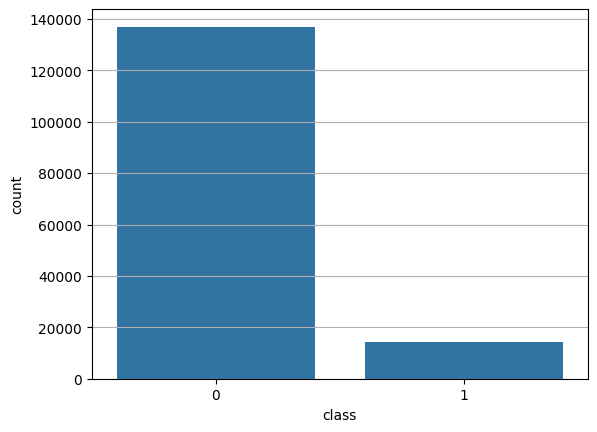

In [6]:
fraud_df['age'].hist(bins=30)
sns.countplot(x='class', data=fraud_df)


<Axes: xlabel='class', ylabel='purchase_value'>

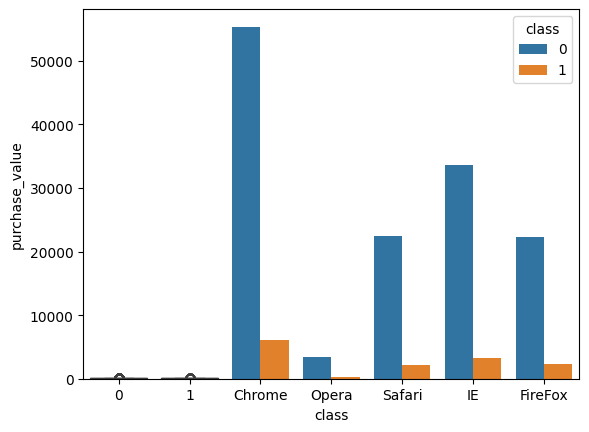

In [7]:
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
sns.countplot(x='browser', hue='class', data=fraud_df)

## Merge Datasets for Geolocation Analysis

In [9]:
fraud_df['ip_address'].head(10)

0    7.327584e+08
1    3.503114e+08
2    2.621474e+09
3    3.840542e+09
4    4.155831e+08
5    2.809315e+09
6    3.987484e+09
7    1.692459e+09
8    3.719094e+09
9    3.416747e+08
Name: ip_address, dtype: float64

In [10]:
fraud_df['ip_integer'] = fraud_df['ip_address'].astype(int)

In [14]:
def map_country(ip, ip_ranges):
    match = ip_ranges[
        (ip_ranges['lower_bound_ip_address'] <= ip) &
        (ip_ranges['upper_bound_ip_address'] >= ip)
    ]
    return match['country'].values[0] if not match.empty else np.nan

fraud_df['country'] = fraud_df['ip_integer'].apply(lambda x: map_country(x, ip_df))


 ## Feature Engineering

In [ ]:
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

In [16]:
fraud_df['user_transaction_count'] = fraud_df.groupby('user_id')['purchase_time'].transform('count')
fraud_df['device_transaction_count'] = fraud_df.groupby('device_id')['purchase_time'].transform('count')

## Data Transformation

In [17]:
print(fraud_df['class'].value_counts(normalize=True))

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


In [22]:
X = fraud_df.drop(columns=[
    'class', 'signup_time', 'purchase_time', 'ip_address', 'country', 
    'user_id', 'device_id'
])

In [23]:
X = pd.get_dummies(X, columns=['browser', 'source', 'sex'], drop_first=True)

In [24]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

y = fraud_df['class']

# Ensure all X columns are numeric now
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [26]:
X = pd.get_dummies(fraud_df, columns=['source', 'browser', 'sex', 'country'], drop_first=True)

## Export Clean Data

In [28]:
fraud_df.to_csv('../data/cleaned_fraud_df.csv', index=False)